In [1]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [2]:
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
X0 = np.kron(X, I)
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

In [3]:
lis = []
lis.append(np.kron(I, I))
temp = np.matmul(X0, SWAP)
lis.append(temp)
lis.append(np.matmul(temp, temp))
lis.append(np.matmul(temp, np.matmul(temp, temp)))

In [4]:
Pi_SR = np.zeros(np.kron(I, I).shape)
for item in lis:
    Pi_SR += (1/len(lis))*item
print(Pi_SR)

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [5]:
unitary_param_1 = [4.20362003, 5.93582256, 1.13444277, 0.80707608, 3.4027251, 0.82820306,
                   0.66563292, 4.04077958]

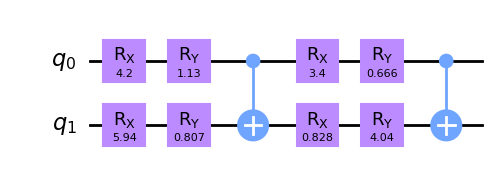

In [6]:
#State \rho_SR
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

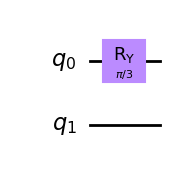

In [13]:
qcTest = QuantumCircuit(2)
qcTest.ry(np.pi/3, 0)
#qcTest.cz(0, 1)
qcTest.draw('mpl')

In [14]:
psi = np.array(DensityMatrix.from_instruction(qcTest.reverse_bits()))
rho = pt(psi, [2], [2, 2]) #rho_S
print(rho)

[[0.75     +0.j 0.4330127+0.j]
 [0.4330127+0.j 0.25     +0.j]]


In [94]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(Pi_SR.shape, complex=True)
G = cp.bmat([[rho, X.H],[X, pt(omega, [2], [2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

c.append(omega == Pi_SR@omega@Pi_SR)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

Root Fidelity is : 0.965922197007493


In [95]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.9330056906717822
